Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch 1/20:
Train Loss: 0.1233, Train Acc: 96.83%
Valid Loss: 0.0321, Valid Acc: 99.06%
Epoch 2/20:
Train Loss: 0.0532, Train Acc: 98.40%
Valid Loss: 0.0250, Valid Acc: 99.30%
Epoch 3/20:
Train Loss: 0.0419, Train Acc: 98.71%
Valid Loss: 0.0240, Valid Acc: 99.32%
Epoch 4/20:
Train Loss: 0.0342, Train Acc: 98.97%
Valid Loss: 0.0275, Valid Acc: 99.16%
Epoch 5/20:
Train Loss: 0.0310, Train Acc: 99.00%
Valid Loss: 0.0207, Valid Acc: 99.36%
Epoch 6/20:
Train Loss: 0.0262, Train Acc: 99.18%
Valid Loss: 0.0216, Valid Acc: 99.44%
Epoch 7/20:
Train Loss: 0.0246, Train Acc: 99.23%
Valid Loss: 0.0243, Valid Acc: 99.30%
Epoch 8/20:
Train Loss: 0.0197, Train Acc: 99.37%
Valid Loss: 0.0230, Valid Acc: 99.50%
Epoch 9/20:
Train Loss: 0.0181, Train Acc: 99.38%
Valid Loss: 0.0234, Valid Acc: 99.44%
Epoch 10/20:
Train Loss: 0.0188, Train Acc: 99.39%
Valid Loss: 0.0273, Valid Acc: 99.22%
Epoch 11/20:
Train Loss: 0.0146, Train Acc: 99.52%
Vali

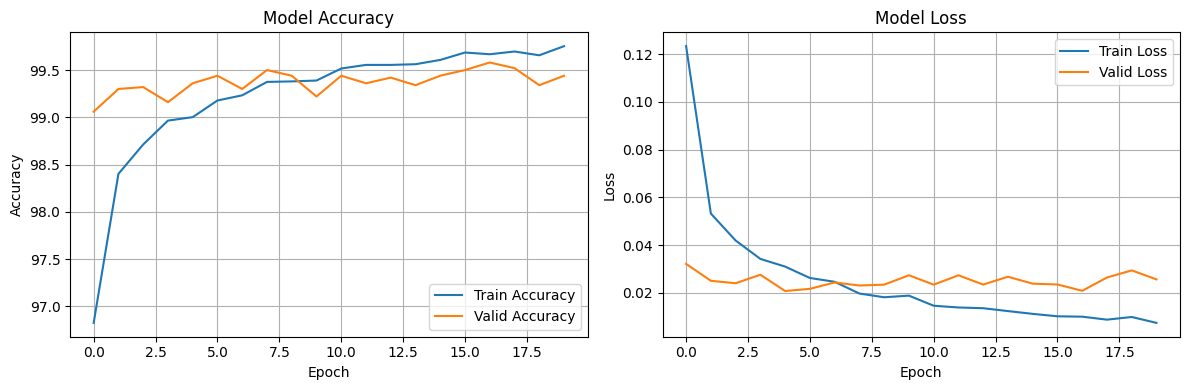

Model zapisany jako 'mnist_model.pth'
Zapisano X_test i y_test


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = list(range(0, len(trainset_full) - 5000))
valid_indices = list(range(len(trainset_full) - 5000, len(trainset_full)))
trainset = Subset(trainset_full, train_indices)
validset = Subset(trainset_full, valid_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

def train_model(model, trainloader, validloader, epochs=12):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(validloader)
        valid_acc = 100 * correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, trainloader, validloader, epochs=20)

model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(testloader)
test_acc = 100 * correct / total
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), "mnist_model.pth")
print("Model zapisany jako 'mnist_model.pth'")
np.save("X_test.npy", testset.data.numpy())
np.save("y_test.npy", testset.targets.numpy())
print("Zapisano X_test i y_test")

Model załadowany z 'mnist_model.pth'
Załadowano X_test i y_test


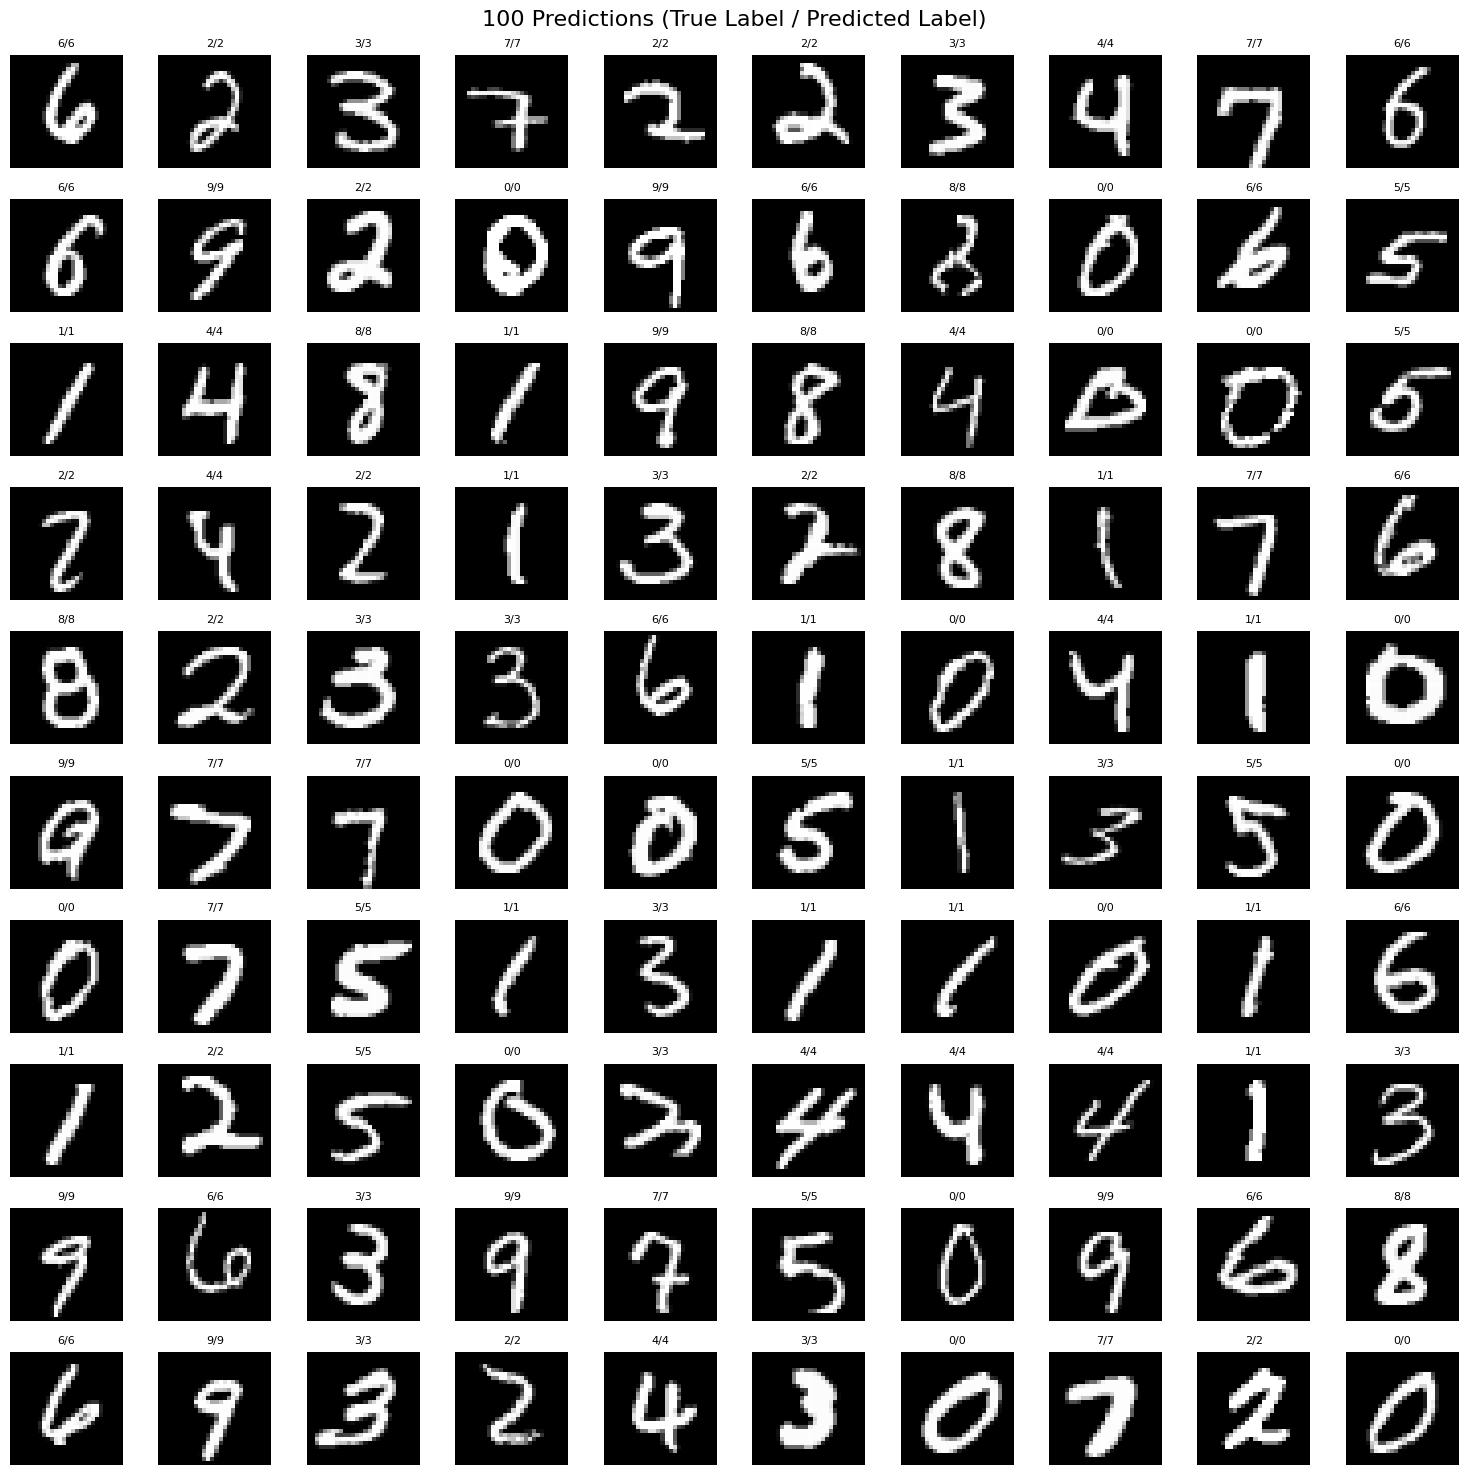

Zapisano siatkę predykcji jako '100_predictions_grid.png'


<Figure size 640x480 with 0 Axes>

In [10]:
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.eval()
print("Model załadowany z 'mnist_model.pth'")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
print("Załadowano X_test i y_test")

#np.random.seed(42) # Tutaj widać jak bardzo ludzie nie umią pisać
indices = np.random.choice(len(X_test), 100, replace=False)

images = torch.tensor(X_test[indices], dtype=torch.float32).unsqueeze(1) / 255.0
images = (images - 0.5) / 0.5
images = images.to(device)
true_labels = y_test[indices]

with torch.no_grad():
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle("100 Predictions (True Label / Predicted Label)", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[indices[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"{true_labels[i]}/{predicted_labels[i]}", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

plt.savefig("100_predictions_grid.png")
print("Zapisano siatkę predykcji jako '100_predictions_grid.png'")

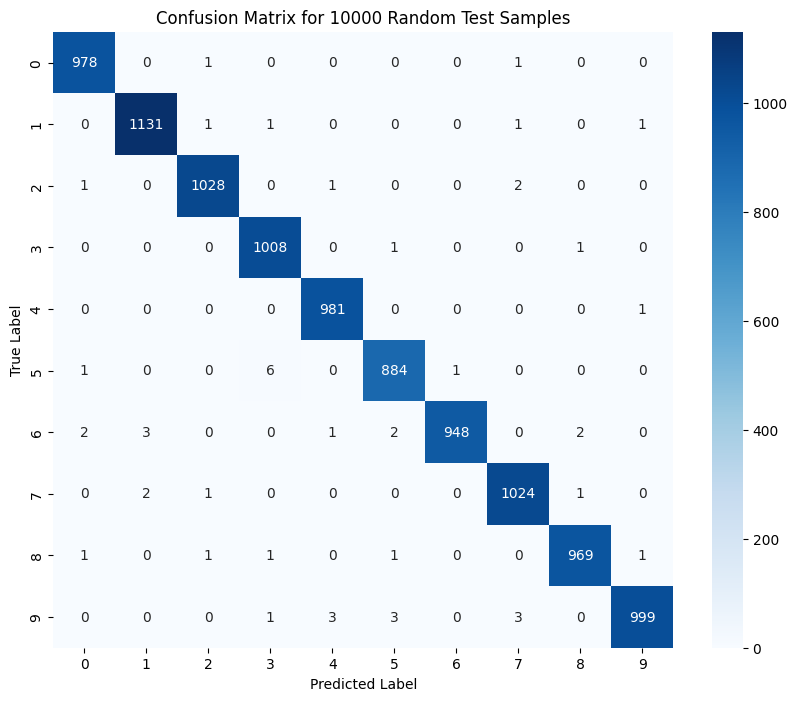

Zapisano macierz pomyłek jako 'confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [11]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

indices = np.random.choice(len(X_test), 10000, replace=False)

images = torch.tensor(X_test[indices], dtype=torch.float32).unsqueeze(1) / 255.0
images = (images - 0.5) / 0.5
images = images.to(device)
true_labels = y_test[indices]

with torch.no_grad():
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for 10000 Random Test Samples")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.savefig("confusion_matrix.png")
print("Zapisano macierz pomyłek jako 'confusion_matrix.png'")

Przewidziana cyfra: 9


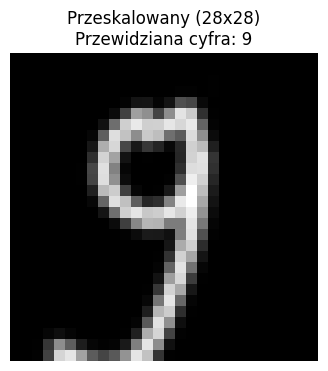

In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)
    img_tensor = (img_tensor - 0.5) / 0.5
    return img_tensor.to(device), transform(img)

def predict_image(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = torch.argmax(output, dim=1).cpu().numpy()[0]
    return predicted_label

def test_custom_image():
    image_path = "cyfra.png"
    try:
        image_tensor, resized_img = load_and_preprocess_image(image_path)
        predicted_label = predict_image(model, image_tensor)
        print(f"Przewidziana cyfra: {predicted_label}")
        
        resized_img_np = resized_img.squeeze().numpy()
        
        plt.figure(figsize=(4, 4))
        plt.imshow(resized_img_np, cmap='gray')
        plt.title(f"Przeskalowany (28x28)\nPrzewidziana cyfra: {predicted_label}")
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Błąd: {e}")

test_custom_image()